In [1]:
%matplotlib inline

import os
import csv

from predpy.dataset import MultiTimeSeriesDataset
from predpy.data_module import MultiTimeSeriesModule
from predpy.wrapper import Autoencoder, Predictor, VAE
from predpy.experimentator import (
    DatasetParams, ModelParams,
    Experimentator, load_experimentator, load_last_experimentator)
from predpy.plotter import (
    plot_exp_predictions
)
from predpy.preprocessing import set_index
from predpy.preprocessing import moving_average
from predpy.preprocessing import (
    load_and_preprocess, set_index, moving_average, drop_if_is_in,
    use_dataframe_func, loc, iloc, get_isoforest_filter, get_variance_filter)
from predpy.trainer import (
    CheckpointParams, TrainerParams, EarlyStoppingParams, LoggerParams)
from predpy.experimentator import LearningParams
from tsad.noiser import apply_noise_on_dataframes, white_noise
from tsad.anomaly_detector import PredictionAnomalyDetector, ReconstructionAnomalyDetector
from models import LSTMAE, LSTMVAE
from literature.anom_trans import AnomalyTransformer, ATWrapper
from literature.velc import VELC, VELCWrapper
from literature.dagmm import DAGMM, DAGMMWrapper
from literature.tadgan import TADGAN, TADGANWrapper
from anomaly_detection.anomaly_detector_base import AnomalyDetector
from models.ideas import LSTMMVR, ConvMVR, MVRWrapper
from models import ConvAE, MultipleConvAE, ConvAEWrapper
from anomaly_detection import (
    AnomalyDetector, fit_run_detection, exp_fit_run_detection,
    get_dataset, get_dataset_names)

from typing import List, Literal
from pytorch_lightning.loggers import TensorBoardLogger
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import TransformerMixin
# from tsai.models import TCN, ResNet, TST, RNN, TransformerModel, FCN
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch import nn
from typing import List, Dict, Literal
from predpy.plotter import plot_anomalies
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score


os.chdir('/home/stachu/Projects/Anomaly_detection/TSAD')
sns.set_style()

In [18]:
def get_a_scores(model, dataloader, return_only_a_score: bool = False):
    a_scores = []
    for batch in tqdm(dataloader):
        x = batch['sequence']
        a_score = model.anomaly_score(
            x, scale=False, return_only_a_score=return_only_a_score)
        a_scores += [a_score]
    return a_scores

def _select_ax(axs, n_rows, n_cols, i, title: str = None):
    ax_row = int(i / n_cols)
    ax_col = i % n_cols
    if n_rows > 1 and n_cols > 1:
        ax = axs[ax_row, ax_col]
    elif n_rows > 1 and n_cols == 1:
        ax = axs[ax_row]
    elif n_rows == 1 and n_cols > 1:
        ax = axs[ax_col]
    else:
        ax = axs
    if title is not None:
        ax.set_title(title)
    return ax

def plot_scores(
    scores: np.ndarray, features_cols: List[int] = None,
    n_rows: int = None, n_cols: int = 2,
    classes: List[Literal[0, 1]] = None,
    figsize=None
):
    if features_cols is None:
        features_cols = list(range(scores.shape[1]))
    if n_rows is not None:
        assert n_rows * n_cols >= len(features_cols)
    else:
        if len(features_cols) < n_cols:
            n_rows, n_cols = 1, len(features_cols)
        else:
            n_rows = math.ceil(len(features_cols)/2)
    if figsize is None:
        figsize = (n_cols * 5, n_rows * 2)

    data = scores[:, features_cols]
    df = pd.DataFrame(
        data, columns=['score_%d' % i for i in features_cols])
    if classes is not None:
        df['classes'] = classes
        hue = 'classes'
    else:
        hue = None

    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, col_id in enumerate(features_cols):
        ax = _select_ax(axs, n_rows, n_cols, i, title='score_%d' % col_id)
        sns.scatterplot(
            data=df,
            x=df.index,
            y='score_%d' % col_id,
            hue=hue,
            ax=ax
        )
    return fig

def plot_kde(
    scores1: np.ndarray, 
    features_cols: List[int] = None,
    scores2: np.ndarray = None,
    n_rows: int = None, n_cols: int = 2,
    figsize=None, scores_names = ['0', '1']
):
    if features_cols is None:
        features_cols = list(range(scores.shape[1]))
    if n_rows is not None:
        assert n_rows * n_cols >= len(features_cols)
    else:
        if len(features_cols) < n_cols:
            n_rows, n_cols = 1, len(features_cols)
        else:
            n_rows = math.ceil(len(features_cols)/2)
    if figsize is None:
        figsize = (n_cols * 5, n_rows * 2)

    # defining data and classes
    if scores2 is not None:
        data = np.concatenate(
            [scores1[:, features_cols], scores2[:, features_cols]])
        classes = [scores_names[0]] * len(scores1) + [scores_names[1]] * len(scores2)
    else:
        data, classes = scores1[:, features_cols], None

    # saving data and classes to DataFrame
    df = pd.DataFrame(
        data, columns=['score_%d' % i for i in features_cols])
    if classes is not None:
        df['classes'] = classes
        hue = 'classes'
    else:
        hue = None

    # plotting selected features
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, col_id in enumerate(features_cols):
        ax = _select_ax(axs, n_rows, n_cols, i)
        sns.kdeplot(
            data=df,
            x='score_%d' % col_id,
            hue=hue,
            common_norm=True,
            ax=ax
        )
    return fig

# Data and model loading

In [3]:
# # scores files: as, only_as
# exp = load_experimentator('./saved_experiments/2022-06-03_17:52:18.pkl')
# model = exp.load_pl_model(0, 'checkpoints/machine-1-1/AnomTrans_l3_d512_lambda3')

# # scores files: as2, only_as2
# exp = load_experimentator('./saved_experiments/2022-06-05_15:43:48.pkl')
# model = exp.load_pl_model(0, 'checkpoints/machine-1-1/AnomTrans_l2_d5_l2')

# # scores files: as3, only_as3
exp = load_experimentator('./saved_experiments/2022-06-05_16:27:49.pkl')
model = exp.load_pl_model(0, 'checkpoints/machine-1-1/AnomTrans_l3_d512_lambda3')
window_size = model.model.N

In [4]:
train_ds = get_dataset(
    'data/Industry/ServerMachineDataset/train/machine-1-1.csv',
    window_size=window_size)
test_ds = get_dataset(
    'data/Industry/ServerMachineDataset/test/machine-1-1.csv',
    window_size=window_size)

train_dl = DataLoader(train_ds, batch_size=1)
test_dl = DataLoader(test_ds, batch_size=1)

test_cls_path = 'saved_scores_preds/ServerMachineDataset/machine-1-1/record_classes/%d.csv' % window_size
test_cls = pd.read_csv(
    test_cls_path, header=None)\
    .iloc[:, 0].to_list()
test_point_cls_path = 'data/Industry/ServerMachineDataset/test_label/machine-1-1.csv'
test_point_cls = pd.read_csv(
    test_point_cls_path, header=None)\
    .iloc[:, 0].to_list()

# Collecting and storing anomaly scores

In [19]:
train_as = get_a_scores(model, train_dl)
train_as = np.array(train_as).squeeze()
# train_as = np.array([el.tolist() for el in train_as]).squeeze()

100%|██████████| 28379/28379 [07:09<00:00, 66.05it/s] 


In [20]:
test_as = get_a_scores(model, test_dl)
test_as = np.array(test_as).squeeze()
# test_as = np.array([el.tolist() for el in test_as]).squeeze()

100%|██████████| 28379/28379 [05:14<00:00, 90.34it/s] 


In [21]:
# # np.save('train_only_as.npy', train_as)
# # np.save('test_only_as.npy', test_as)
np.save('train_as3.npy', train_as)
np.save('test_as3.npy', test_as)

In [9]:
# train_as = np.load('train_only_as.npy')
# test_as = np.load('test_only_as.npy')

In [198]:
scaler = MinMaxScaler()
s_train_as = scaler.fit_transform(train_as)
s_test_as = scaler.transform(test_as)

# Plotting features

In [199]:
# from scipy.stats import norm
# threshold = norm.ppf(0.99)

# pred_cls = np.where(test_a_scores > threshold)

In [200]:
# fig = plot_kde(
#     features_cols=list(range(78)),
#     n_rows=39, n_cols=2, figsize=(20, 156),
#     scores1=s_test_as[np.argwhere(np.array(test_cls) == 0).squeeze()],
#     scores2=s_test_as[np.argwhere(np.array(test_cls) == 1).squeeze()],
#     scores_names=['normal', 'anomaly']);
# fig.savefig('scores.png')
# plt.close()

[12, 24, 36, 48, 60, 72, 84, 96]


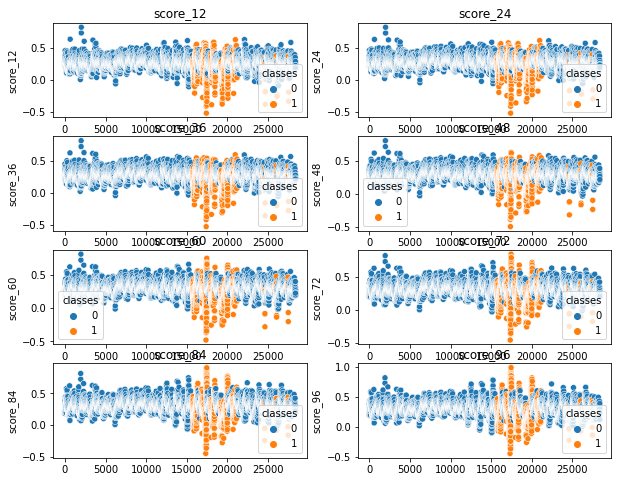

In [201]:
fig = plot_scores(s_test_as, classes=test_cls, features_cols=list(range(12, 101, 12)))

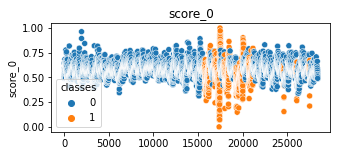

In [230]:
fig = plot_scores(s_test_as[:, 76:77], classes=test_cls, features_cols=[0])

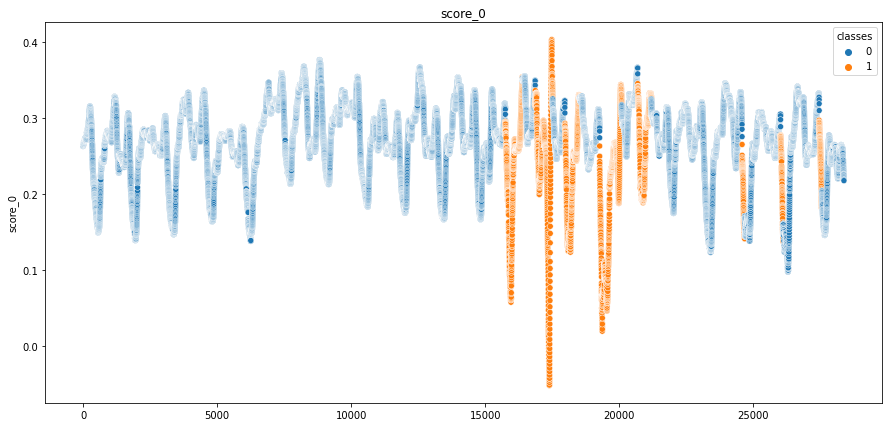

In [203]:
fig = plot_scores(np.mean(s_test_as, axis=1).reshape(-1, 1), classes=test_cls, features_cols=[0], figsize=(15, 7))

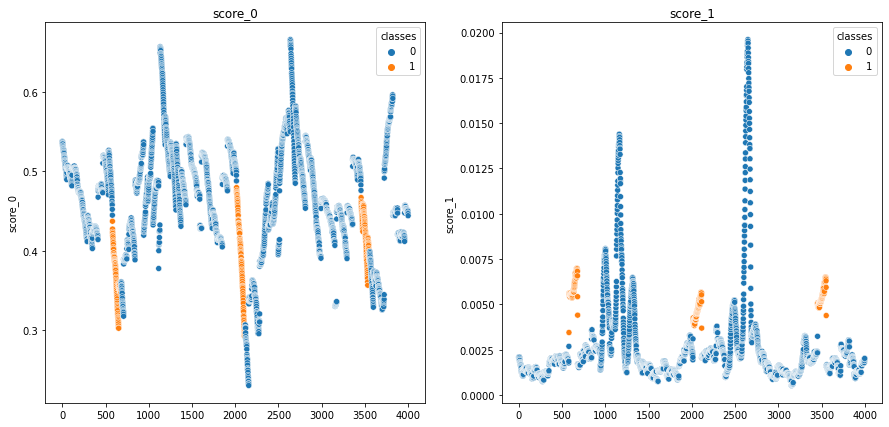

In [204]:
s_var = np.var(s_test_as, axis=1)[24000:28000]
s_max = np.max(s_test_as, axis=1)[24000:28000]
collected_scores = np.stack([s_max, s_var], axis=1)
fig = plot_scores(collected_scores, classes=test_cls[24000:28000], figsize=(15, 7))

# Projecting record scores to data point scores

In [205]:
s_var = np.var(s_test_as, axis=1)
s_max = np.max(s_test_as, axis=1)
collected_scores = np.stack([s_var, s_max], axis=1)

df = pd.DataFrame(zip(s_max, s_var), columns=['max', 'var'])
df = df.rolling(window_size*2 + 1, center=True).max()
df.iloc[:window_size] = [s_max[0], s_var[0]]
df.iloc[-window_size:] = [s_max[-1], s_var[-1]]

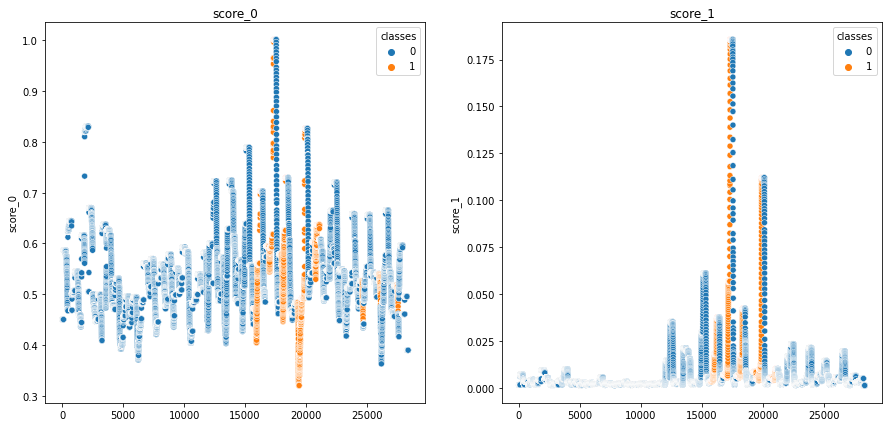

In [206]:
fig = plot_scores(df.to_numpy(), classes=test_cls, figsize=(15, 7))

## Record anomaly scores to data point anomalies scores

In [207]:
data = s_test_as[[i*window_size for i in range(int(len(s_test_as)/window_size)+1)]].reshape(-1)

n_rest = s_test_as.shape[0] - data.shape[0] + window_size
data = np.concatenate([
    data,
    s_test_as[-1][-n_rest:]
])

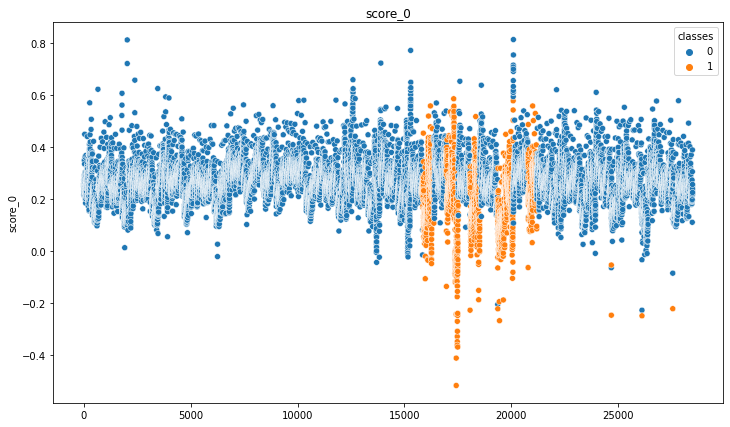

In [208]:
plot_scores(data.reshape(-1, 1), figsize=(12, 7), classes=test_point_cls);

In [209]:
s_rec_max = pd.Series(data).rolling(window_size).max().dropna()[:-1].to_numpy()

In [210]:
pred_cls = np.zeros(len(test_cls))
pred_cls[np.where(s_rec_max > 2)[0]] = 1

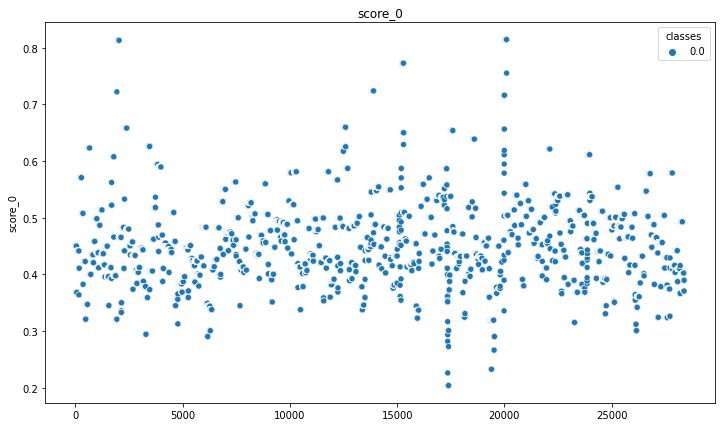

In [211]:
plot_scores(s_rec_max.reshape(-1, 1), figsize=(12, 7), classes=pred_cls);

# Fitting logistic regression

In [212]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score

lr = LogisticRegression().fit(s_test_as, test_cls)
pred_cls = lr.predict(s_test_as)

cm = confusion_matrix(test_cls, pred_cls)
fb_score = fbeta_score(test_cls, pred_cls, beta=1, average='binary')

fb_score, cm

(0.15604337476857974,
 array([[24893,     0],
        [ 3191,   295]]))

In [213]:
# most important
best_cols = np.argwhere(lr.coef_ > 0.0)[:, 1]
best_cols

array([ 0,  1,  2,  3,  4,  5,  6,  7, 99])

In [214]:
cols = list(range(78))
lr2 = LogisticRegression().fit(s_test_as[:, cols], test_cls)
pred_cls = lr2.predict(s_test_as[:, cols])

cm = confusion_matrix(test_cls, pred_cls)
fb_score = fbeta_score(test_cls, pred_cls, beta=1, average='binary')

fb_score, cm

(0.15888097123251516,
 array([[24891,     2],
        [ 3185,   301]]))

# Setting threshold

In [215]:
pred_cls = np.zeros(len(test_cls))
pred_cls[np.argwhere(s_test_as > 1.4)[:, 0]] = 1

cm = confusion_matrix(test_cls, pred_cls)
fb_score = fbeta_score(test_cls, pred_cls, beta=1, average='binary')

fb_score, cm

(0.0,
 array([[24893,     0],
        [ 3486,     0]]))

In [216]:
x_max = np.max(s_test_as[:, :38], axis=1)
x_l2 = np.max(s_test_as[:, 38:76], axis=1)

data = np.stack([x_max, x_l2, s_test_as[:, 76], s_test_as[:, 77]], axis=1)

pred_cls = np.zeros(len(test_cls))
pred_cls[np.argwhere(data > 2)[:, 0]] = 1

cm = confusion_matrix(test_cls, pred_cls)
fb_score = fbeta_score(test_cls, pred_cls, beta=1, average='binary')

fb_score, cm

(0.0,
 array([[24893,     0],
        [ 3486,     0]]))

/tmp/ipykernel_3434/3241031043.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



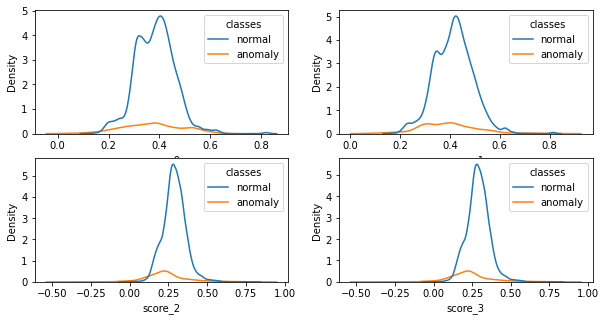

In [217]:
fig = plot_kde(
    features_cols=list(range(4)),
    n_rows=2, n_cols=2, figsize=(10, 5),
    scores1=data[np.argwhere(np.array(test_cls) == 0).squeeze()],
    scores2=data[np.argwhere(np.array(test_cls) == 1).squeeze()],
    scores_names=['normal', 'anomaly'])
fig.show();

## Modeling scores with gaussian distribution

In [218]:
def fit_test_gaussian(train_data: np.ndarray, test_data: np.ndarray, test_cls: np.ndarray):
    mean = np.mean(train_data, axis=0)
    cov = np.cov(train_data, rowvar=0)

    mn = multivariate_normal(mean, cov)

    p = len(np.where(test_cls == 1)[0])
    prop = p/len(test_cls)
    # c = 0.298095
    test_pdf = mn.pdf(test_data)
    lr = LogisticRegression(
        class_weight={0: prop, 1: 1-prop}
    )
    lr = lr.fit(test_pdf.reshape(-1, 1), test_cls)
    pred_cls = lr.predict(test_pdf.reshape(-1, 1))

    cm = confusion_matrix(test_cls, pred_cls)
    fb_score = fbeta_score(test_cls, pred_cls, beta=1, average='binary')

    return mn, lr, test_pdf, fb_score, cm

In [219]:
# collecting point scores
data = s_test_as[[i*window_size for i in range(int(len(s_test_as)/window_size)+1)]].reshape(-1)
n_rest = s_test_as.shape[0] - data.shape[0] + window_size
data = np.concatenate([
    data,
    s_test_as[-1][-n_rest:]
])

# p = len(np.where(np.array(test_cls) == 1)[0])
# prop = p/len(test_cls)

# collecting record scores statistics
rol = pd.Series(data).rolling(window_size, center=True)
s_max = rol.max().dropna().to_numpy()
s_var = rol.var().dropna().to_numpy()
s_sum = rol.sum().dropna().to_numpy()
scores = np.stack([
    s_max,
    # s_var,
    # s_sum
], axis=1)[1:]
# lr = LogisticRegression(class_weight={0: prop, 1: 1-prop}).fit(scores, test_cls)
# pred_cls = lr.predict(scores)


cm = confusion_matrix(test_cls, pred_cls)
f1_score = fbeta_score(test_cls, pred_cls, beta=1, average='binary')
# _, _, _, f1_score, cm = fit_test_gaussian(scores[:15000], scores, np.array(test_cls))
f1_score, cm

(0.0,
 array([[24893,     0],
        [ 3486,     0]]))

## Tests on x_max(38), x_l2(38), s_max, s_mean

In [220]:
x_max = np.max(s_train_as[:, :38], axis=1)
x_l2 = np.max(s_train_as[:, 38:76], axis=1)
train_data = np.stack([x_max, x_l2, s_train_as[:, 76], s_train_as[:, 77]], axis=1)

x_max = np.max(s_test_as[:, :38], axis=1)
x_l2 = np.max(s_test_as[:, 38:76], axis=1)
test_data = np.stack([x_max, x_l2, s_test_as[:, 76], s_test_as[:, 77]], axis=1)

_, _, _, f1_score, cm = fit_test_gaussian(train_data, test_data, np.array(test_cls))
f1_score, cm

(0.29303386559045447,
 array([[13787, 11106],
        [  981,  2505]]))

In [221]:
_, _, _, f1_score, cm = fit_test_gaussian(s_train_as[:, 76:78], s_test_as[:, 76:78], np.array(test_cls))
f1_score, cm

(0.24943003265758829,
 array([[14174, 10719],
        [ 1462,  2024]]))

In [222]:
train_data = np.stack([
    np.max(s_train_as, axis=1),
    # np.mean(s_train_as, axis=1),
    # np.var(s_train_as, axis=1),
    # np.min(s_train_as, axis=1)
], axis=1)
test_data = np.stack([
    np.max(s_test_as, axis=1),
    # np.mean(s_test_as, axis=1),
    # np.var(s_test_as, axis=1),
    # np.min(s_test_as, axis=1)
], axis=1)

# s_max = np.max(s_test_as, axis=1)
# s_mean = np.mean(s_test_as, axis=1)
# s_var = np.var(s_test_as, axis=1)
# s_min = np.min(s_test_as, axis=1)
# test_data = np.stack([s_max, s_mean, s_var, s_min], axis=1)

_, _, _, f1_score, cm = fit_test_gaussian(train_data, test_data, np.array(test_cls))
f1_score, cm

(0.25946940653274037,
 array([[17029,  7864],
        [ 1794,  1692]]))

# Fitting LR on one example of anomaly

In [23]:
# data shape: 38 xd_max + 38 xd_l2 + 1 s_max + 1 s_mean
# train_as = np.load('train_as3.npy')
# test_as = np.load('test_as3.npy')

scaler = MinMaxScaler()
s_train_as = scaler.fit_transform(train_as)
s_test_as = scaler.fit_transform(test_as)

In [24]:
s_train_as[15000:19000, 0:1].shape

(4000, 1)

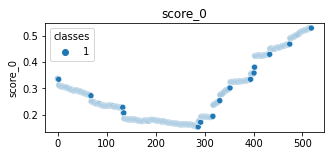

In [25]:
plot_scores(
    s_train_as[15849:16368, 0:1],
    classes=np.array(test_cls[15849:16368])
);

In [29]:
lr_train_scores = np.concatenate([s_test_as[:1000], s_test_as[15849:16368]], axis=0)
lr_train_cls = [0] * 1000 + [1] * (16368 - 15849)

lr = LogisticRegression().fit(lr_train_scores, lr_train_cls)
# lr = LogisticRegression().fit(s_test_as, test_cls)
pred_cls = lr.predict(s_test_as)

cm = confusion_matrix(test_cls, pred_cls)
f1_score = fbeta_score(test_cls, pred_cls, beta=1, average='binary')
f1_score, cm

(0.7018156424581007,
 array([[22802,  2091],
        [  471,  3015]]))

In [30]:
s_test_as.shape

(28379, 78)

## Rec cls to point cls

In [27]:
s = pd.Series(pred_cls)
# .rolling(window_size*2 + 1, center=True).max()
new_pred_cls = s.index.to_series().apply(lambda idx: max(
    s.iloc[max(0, idx-window_size):idx+window_size+1])).to_numpy()

In [28]:
cm = confusion_matrix(test_cls, new_pred_cls)
f1_score = fbeta_score(test_cls, new_pred_cls, beta=1, average='binary')
f1_score, cm

(0.7804711505633322,
 array([[23021,  1872],
        [   57,  3429]]))